# Exploring the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years,
as part of the Portland Data Science group (Oct 2017).
Data selected by Matt Borthwick from Yahoo! Finance.  Working with Trenton, and Hitesh.

In [181]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import datetime

%matplotlib

Using matplotlib backend: nbAgg


In [2]:
df=pd.read_csv('stocks-us-adjClose.csv',skiprows=1,index_col=0,parse_dates=True)

<IPython.core.display.Javascript object>


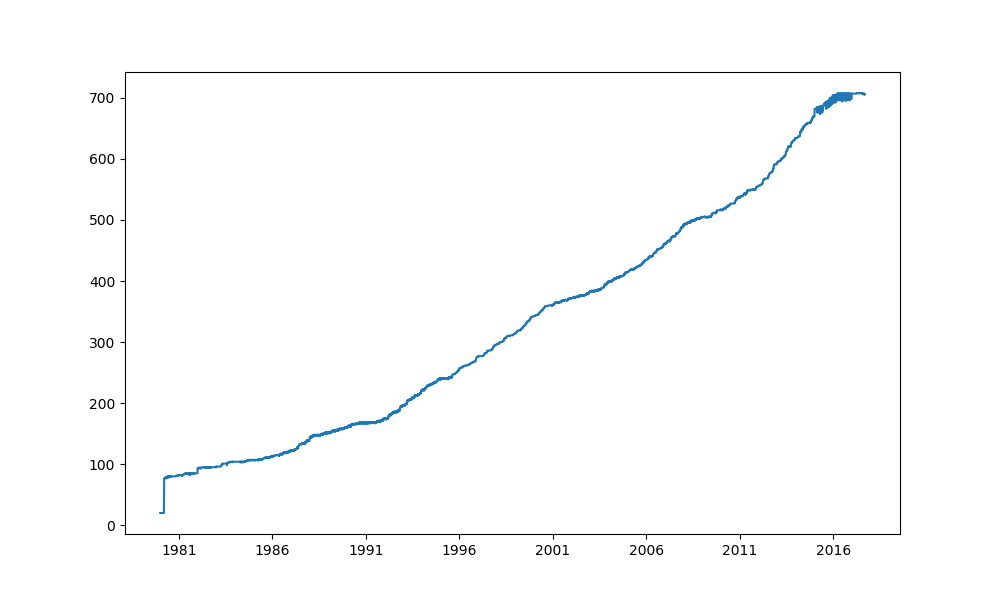

In [182]:
#Plot the number of tickers.  Seems to suggest ignoring anything prior to 1980. 
plt.figure(1,figsize=(10,6))
Ntick=np.sum(df>0,axis=1)
plt.plot(Ntick)
plt.show()

<IPython.core.display.Javascript object>


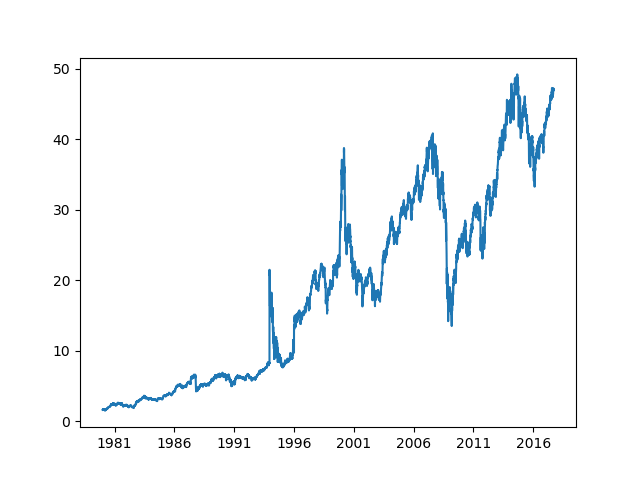

In [49]:
#ditch all rows prior to 1980.
msk=df.index>'1980'  
df=df[df.index>'1980']
plt.figure()
plt.plot(df.mean(axis=1))
plt.show()

## Question ideas:

1) Can you detect a bubble? 
2) Can you estimate non-Gaussianities (power-law on changes) i.e. skewness/kurtosis. (yes)
3) What is the overall trend of the market?  (Linear fit)
4) (Hitesh idea) Is the distribution of price changes different in months when quarterly reports are released?
5) Can you predict the values of stocks via an ARIMA model.

In [50]:
#Try taking difference across time of series.  Then take histogram.  
df2=np.log10(df)
df3=np.log10(df).diff()

In [58]:
%pdb

Automatic pdb calling has been turned ON


In [209]:
def diff_summary(df,lag=1,avg_axis=0):
    """diff_summary(df,lag=1)
    
    Calculate the moments for each column of a dataframe.
    Compute mean, variance, skewness and kurtosis for each column 
    independently.
    """
    col_names=['mean','var','skew','kurt']
    dat_summary = pd.DataFrame(index=df.columns,columns=col_names)
    dat=np.log(df).diff(lag)
    dat_summary['mean']=dat.mean(axis=avg_axis)
    dat_summary['var']=dat.var(axis=avg_axis)
    dat_summary['skew']=dat.skew(axis=avg_axis)
    dat_summary['kurt']=dat.kurt(axis=avg_axis)
    return dat_summary

def plot_moments_hist(d0_sum,title):
    """plot_moments_hist(d0_sum,title)
    Make 4 plots of histograms of the summary statistics for each stock
    ticker.  Shows the distribution of deviations from non-Gaussianity.
    Skew and Kurtosis are of greatest interest here. 

    """
    d1 = d0_sum.dropna(axis=0)
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.subplot(2,2,1)
    plt.hist(d1['mean'],bins=20,log=True)
    plt.xlabel('Mean')

    plt.subplot(2,2,2)
    plt.hist(d1['var'],bins=20,log=True)
    plt.xlabel('Variance')
    
    plt.subplot(2,2,3)
    plt.hist(d1['skew'],bins=20,log=True)
    plt.xlabel('Skew')
    
    plt.subplot(2,2,4)
    plt.hist(d1['kurt'],bins=100,log=True)
    plt.xlabel('Kurtosis')
    plt.show()
    return None


<IPython.core.display.Javascript object>


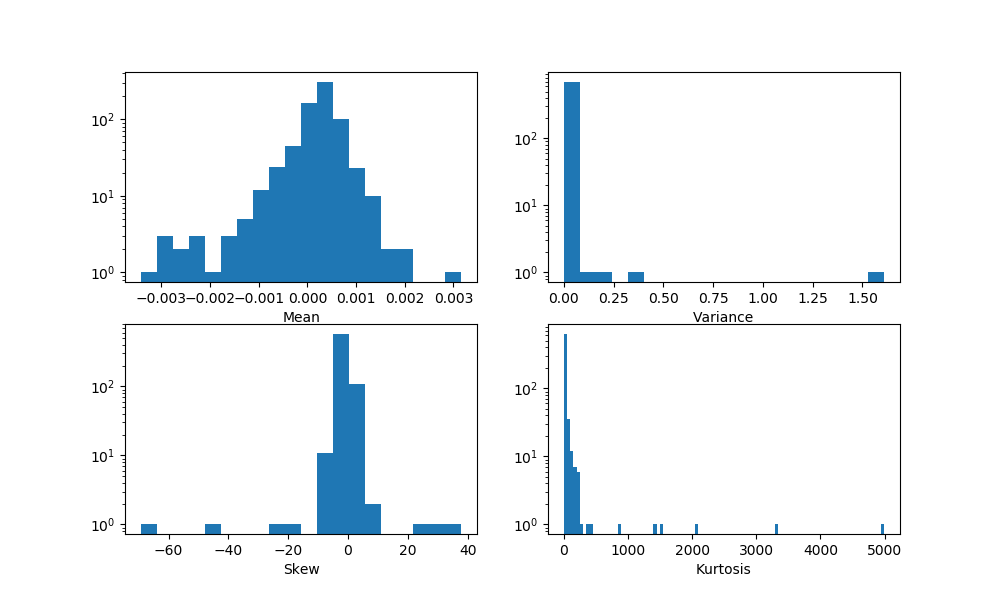

<IPython.core.display.Javascript object>


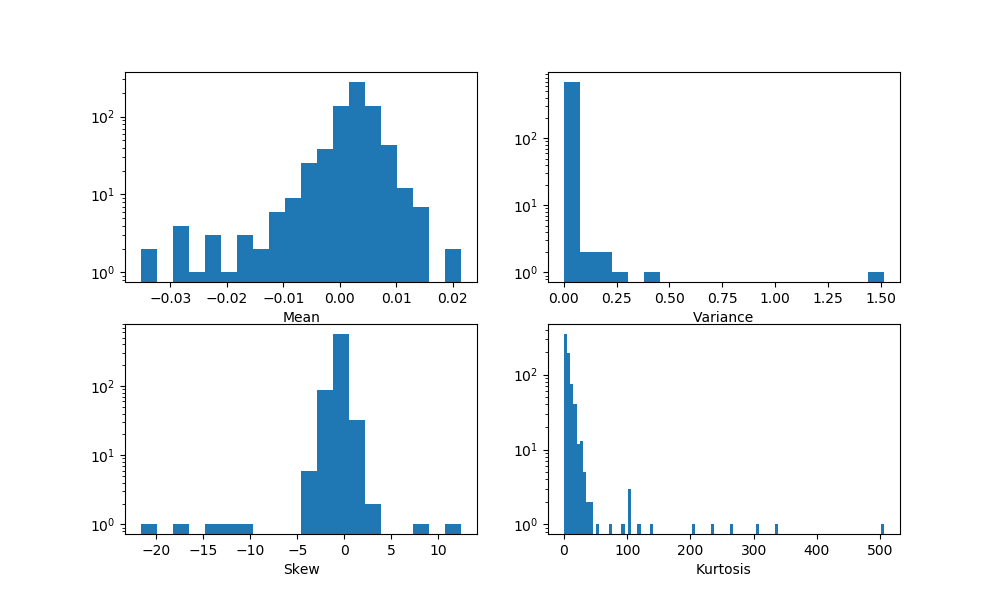

<IPython.core.display.Javascript object>


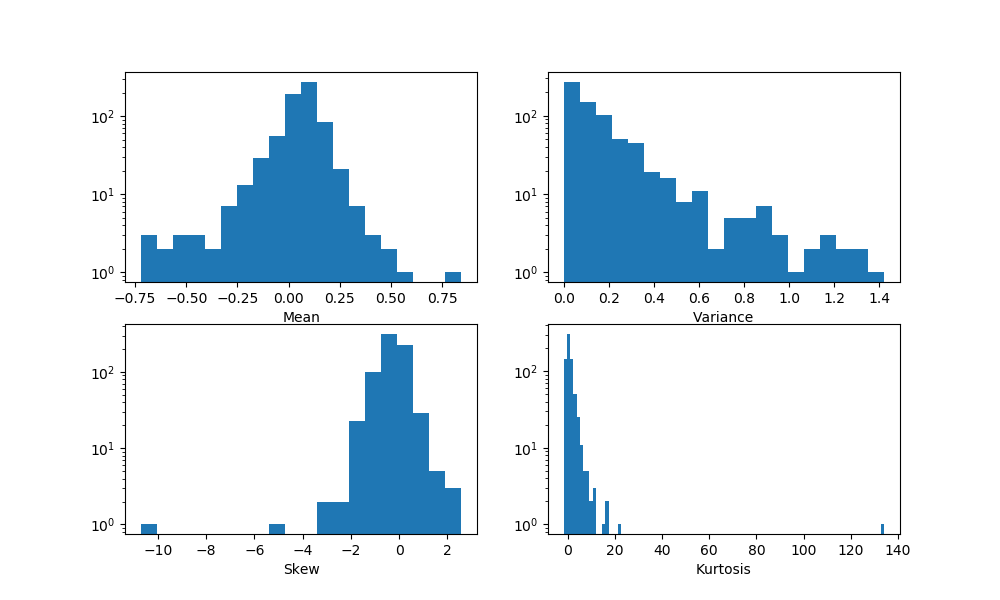

<IPython.core.display.Javascript object>


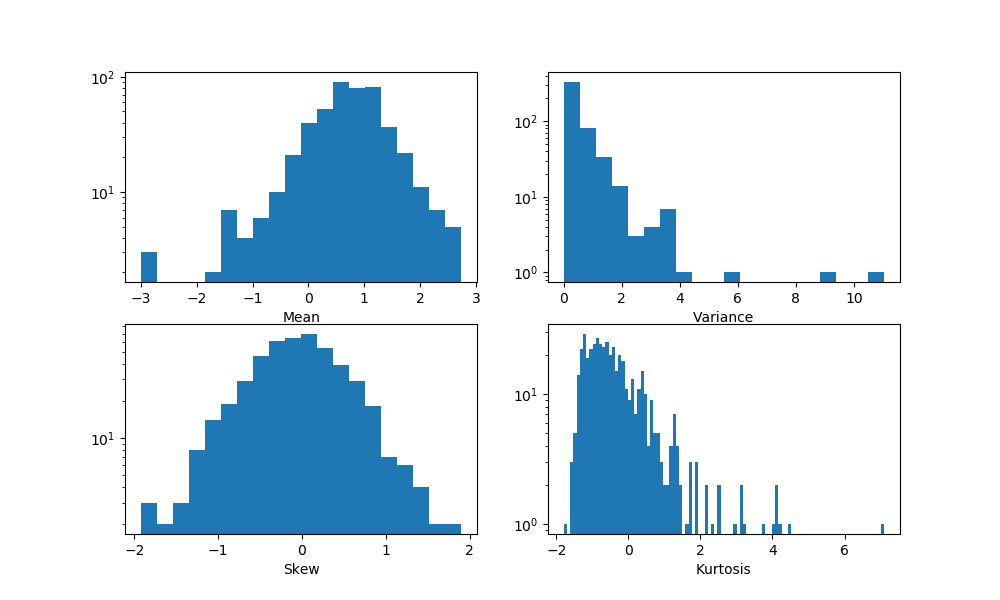

In [212]:
#Make plots of the summary statistics for the price changes in each series as a function of
# the lag.  (lag=1, 1 day; lag=5, 1 week, lag=250 ~ 1 year)
d0=diff_summary(df,lag=1)
d0=d0.dropna(axis=0)
#plot all of the moments

plot_moments_hist(d0,'Summary Statistics Price Changes for Each Series - 1 day')

#Make plots of the summary statistics for the price changes in each series as a function of
# the lag.  (lag=1, 1 day; lag=5, 1 week, lag=250 ~ 1 year)
d0=diff_summary(df,lag=10)
d0=d0.dropna(axis=0)
#plot all of the moments

plot_moments_hist(d0,'Summary Statistics Price Changes for Each Series - 2 weeks')
#Make plots of the summary statistics for the price changes in each series as a function of
# the lag.  (lag=1, 1 day; lag=5, 1 week, lag=250 ~ 1 year)
d0=diff_summary(df,lag=250)
d0=d0.dropna(axis=0)
#plot all of the moments
plot_moments_hist(d0,'Summary Statistics Price Changes for Each Series - 50 weeks')

#Make plots of the summary statistics for the price changes in each series as a function of
# the lag.  (lag=1, 1 day; lag=5, 1 week, lag=250 ~ 1 year)
d0=diff_summary(df,lag=2500)
d0=d0.dropna(axis=0)
#plot all of the moments
plot_moments_hist(d0,'Summary Statistics Price Changes for Each Series - 10 years')

# What is average rate of return?

If we look at the average rate of return for all the stocks, there is a clear exponential trend.
This section fits a linear model to the mean log-stock price.
Would be interesting to compare to the current rate on long term government assets (100 year bonds?),
and estimated rate of inflation.  The Fed lending rate might not be a good comparison, since
the Federal Reserve is used to try to control the economy.  

<IPython.core.display.Javascript object>


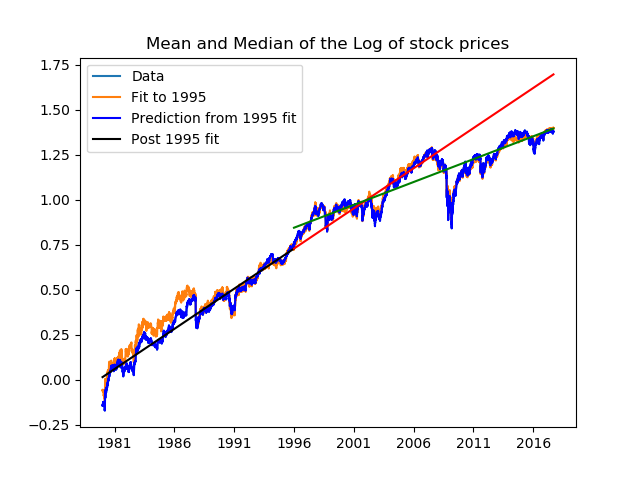

In [53]:
plt.figure()
plt.plot(df2.mean(axis=1),'-',df2.median(axis=1),'-')
plt.legend(['Mean','Median'])
plt.title('Mean and Median of the Log of stock prices') 
plt.show()

In [104]:
# # Try a simple linear regression, just to get it to work.

# LR=lm.LinearRegression()
# # times=train_dat.index.values
# # val=train_dat.values
# x = np.arange(20).reshape(-1,1)
# y = 2*x+3+np.random.randn(20).reshape(-1,1)
# LR.fit(x.reshape(-1,1),y)
# z=LR.predict(x)
# plt.plot(x,y,x,z)
# #plt.plot(x,y)
# plt.show()


In [20]:
%pdb

Automatic pdb calling has been turned OFF


In [54]:

#Split the data into training and test data, with a break at 1995.
#As we'll see, thats an unfortunate choice. 
msk=df.index.year<=1995
df_train=np.log10(df[msk])
df_test=np.log10(df[~msk])

train_dat=df_train.mean(axis=1)
test_dat=df_test.mean(axis=1)

In [55]:
#Try Linear regression on mean log-stock price.
LR=lm.LinearRegression()
#times=train_dat.index.values.reshape(-1,1)
#In order to get scikit-learn to work, I had to do two things:
# 1)convert the pandas datetimeindex to an integer (in this case, the julian date, which I think is the number of days since 1 AD).
# 2)convert the result array to a list of lists via the weird reshape.
#Both of these were found via judicious googling/reading stackoverflow.

jdate  =train_dat.index.to_julian_date().values.reshape(-1,1)

val=train_dat.values.reshape(-1,1)
#Carry out the fitting.
LR.fit(jdate,val)
#now show fit on training set.  
z_fit=LR.predict(jdate)
c1=LR.coef_
z_fit=z_fit.reshape(len(z_fit))
z_fit=pd.Series(z_fit,index=train_dat.index)

#Do prediction for the testing data
jdate2 = test_dat.index.to_julian_date().values.reshape(-1,1)
z_pred=LR.predict(jdate2)
z_pred=z_pred.reshape(len(z_pred))
z_pred=pd.Series(z_pred,index=test_dat.index)

#Carry out alternative linear fit on testing data.
val2=test_dat.values.reshape(-1,1)
LR.fit(jdate2,val2)
c2=LR.coef_
z_pred2=LR.predict(jdate2)
z_pred2=z_pred2.reshape(len(z_pred2))
z_pred2=pd.Series(z_pred2,index=test_dat.index)

#Could use mean square error as metric for fit.
#Other metrics might be more suitable depenending on desired sensitivity?

#now compare against test.  


In [56]:
len(train_dat['1985'])

252

In [57]:
#Attempt to compute return per annum based on linear trend.
#Raise power of 10 due to using log10 earlier.
#The fit is coefficients per day, so find change after ~252 days. (like exp( rate * days)
mean_ROR=10**(np.array([c1,c2])*252)-1
print('Mean rate of return before 1995: {}, after 1995:{}'.format(mean_ROR[0],mean_ROR[1]) )

Mean rate of return before 1995: [[ 0.07348276]], after 1995:[[ 0.04118839]]


<IPython.core.display.Javascript object>


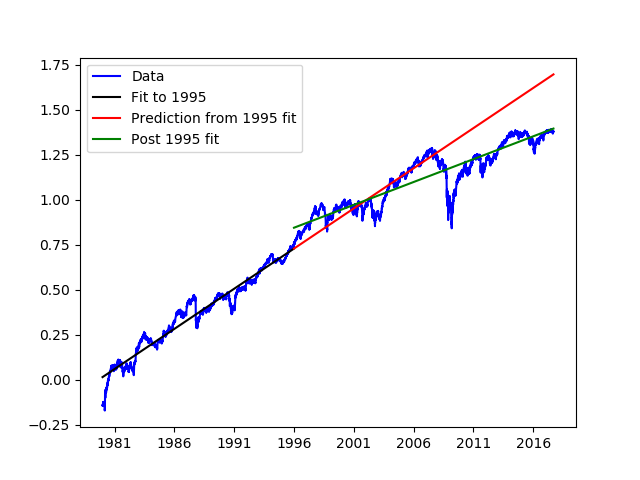

In [59]:
#Plot the training/fitted data.  Compare the pre-1995 fit and predictin to the post-1995 fit.
plt.figure()
plt.plot(train_dat.append(test_dat),'b',z_fit,'k',z_pred,'r',z_pred2,'g')
plt.legend(['Data','Fit to 1995','Prediction from 1995 fit','Post 1995 fit'])
plt.show()


In [28]:
c2=df2['2013'].corr()

In [27]:
plt.imshow(c2)
plt.show()

In [139]:
plt.imshow(df2)
plt.show()


# Better Models

I've found the Auto-Regressive, Integrated, Moving Average (ARIMA) models seem to be a broad, powerful class of linear models.
This would be a good baseline for comparison with more exotic/black box models such as neural networks (RNN). 

ARIMA models have built in support in scikit-learn. RNN should be easy to implement in TensorFlow.

I've also seen some authors suggest state-space methods, such as the Kalman filter.  I.e. predict the mean, and variance of the distribution.
(I'm exposed to this in particle monitoring in noisy environments, where there is a uncertainty of in a particles position, and noise in the measurement process.  I'm not entirely sure about how to use that mental model here)

For the following ARIMA work, I am liberally ripping off the blogpost at :
https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c.
I am also relying on "NonLinear Time Series Models in Empirical Finance" by Franses and van Dijk.

In [204]:
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [81]:
?df3.rolling

<IPython.core.display.Javascript object>


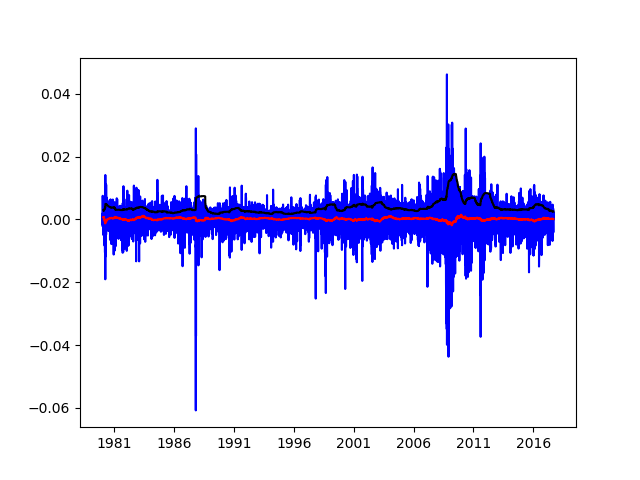

In [201]:
plt.figure()
ts=df3.mean(axis=1)
rolmean=ts.rolling(window=200,center=False,min_periods=20).mean()
rolstd=ts.rolling(window=200,center=False,min_periods=20).std()

plt.plot(ts,'b',rolmean,'r',rolstd,'k')
plt.show()

In [ ]:
mean_stk=df2.mean(axis=1)
#Check for stati

In [108]:
mean_stk=df2.mean(axis=1)
mean_stk_diff=df3.mean(axis=1)
#Check for stationarity 
def test_stationary(ts):
    "Carry out Augmented Dickey Fuller Tests for a given time series"
    ts.dropna(inplace=True)
    test_result=adfuller(ts)
    names=['adf_score','p-value','lag','nobs','critical values']
    for i in range(5): print(names[i],test_result[i])
    return None
print('Mean Stock Price')
test_stationary(mean_stk)
print('Mean Stock Price Diff')
test_stationary(mean_stk_diff)


Mean Stock Price
adf_score -1.87999493357
p-value 0.341529849129
lag 27
nobs 9478
critical values {'1%': -3.4310401320883073, '5%': -2.8618449954805274, '10%': -2.5669323439935159}
Mean Stock Price Diff
adf_score -14.4050454761
p-value 8.3847884014e-27
lag 38
nobs 9466
critical values {'1%': -3.4310410072026589, '5%': -2.8618453821816892, '10%': -2.5669325498358599}


Screwing around with the Dickey-Fuller tests suggests that the differences of the log-prices are probably stationary.
(Again, we'd anticipate random walks to be a pretty good simple model.)  There is around 30 days of autocorrelation suggested.  

### Autocorrelation Functions

Lets now check out the auto-correlation functions.  For simplicity, let's just try this on the mean value of the stock prices.  (A somewhat meaningless measure, but it might be more representative than a single stock)

<IPython.core.display.Javascript object>


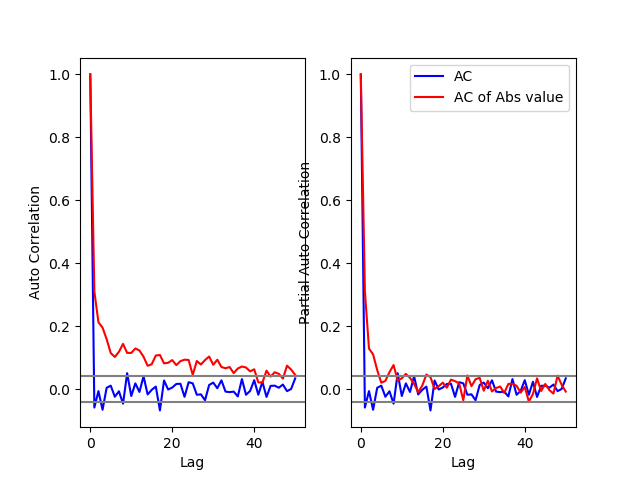

In [128]:
mean_stk_diff=df3.mean(axis=1).dropna()
def plot_acf(ts,nl=50):
    #Actually do those auto-corellations, on the series, and its absolute value.
    lag_acf=acf(ts,nlags=nl)
    lag_pacf=pacf(ts,nlags=nl,method='ols')
    abs_lag_acf=acf(abs(ts),nlags=nl)
    abs_lag_pacf=pacf(abs(ts),nlags=nl,method='ols')
    #5% confidence intervals.
    sd = 1.96/np.sqrt(len(ts))
    #Make some purty subplots.
    plt.figure()
    plt.subplot(121)
    plt.ylabel('Auto Correlation')
    plt.plot(lag_acf,'b',abs_lag_acf,'r')
    plt.axhline(y=sd,color='gray')
    plt.axhline(y=-sd,color='gray')
    plt.ylabel('Auto Correlation')
    plt.xlabel('Lag')
    plt.subplot(122)
    plt.ylabel('Partial Auto Correlation')
    plt.xlabel('Lag')
    plt.plot(lag_acf,'b',abs_lag_pacf,'r')
    plt.axhline(y=sd,color='gray')
    plt.axhline(y=-sd,color='gray')
    plt.legend(['AC','AC of Abs value'])
    plt.show()
    return None

plot_acf(df3.iloc[:,500].dropna())

So, eyeballing the average stock price suggests that there is pretty much zero correlation.  There are a bunch of weird, small wiggles at various lags.  However, all those wiggles fall within the 5% confidence bounds on zero, so we can ignore them.  

Following Frances and van Dijk, I also plotted the correlations for the absolute value of the changes.  The absolute values show a long lived correlation.  Perhaps suggesting something about a larger market memory about how much a stock price is changing by?  

In [214]:
?train_dat.index()

In [232]:
#def train_and_fit_arima(ts):

#resample to weekly data
mean_stk_week = mean_stk.resample('W').mean()

year_cut='2005'
msk= mean_stk_week.index<year_cut
#split into training/test data before/after 2016
train_dat=mean_stk_week[msk]
test_dat=mean_stk_week[~msk]

decomposition = seasonal_decompose(train_dat)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


<IPython.core.display.Javascript object>


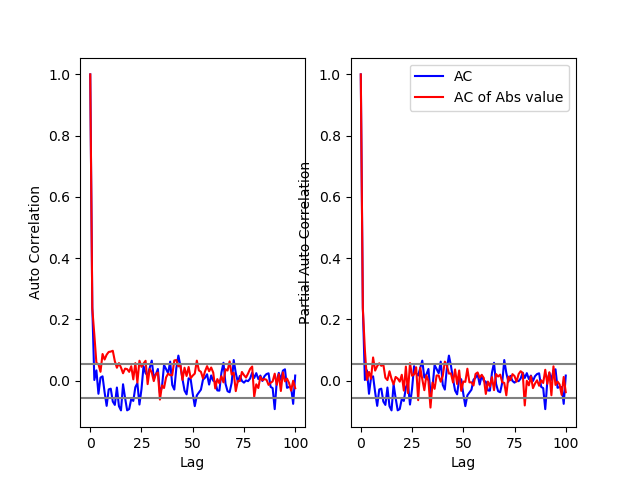

In [238]:
plot_acf(residual.diff().dropna(),nl=100)

<IPython.core.display.Javascript object>


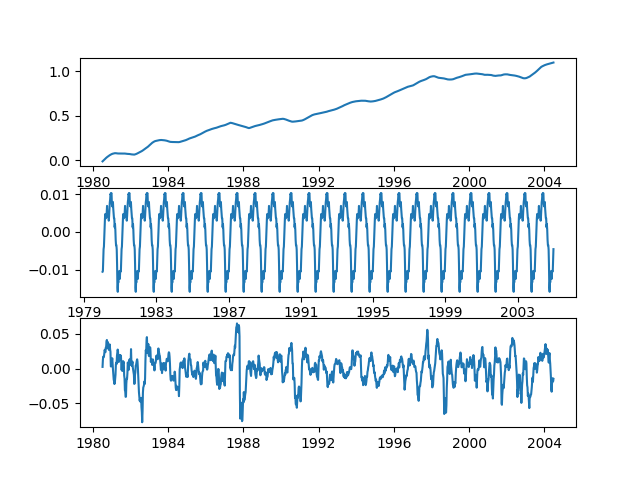

In [233]:
plt.figure()
plt.subplot(311)
plt.plot(trend)
plt.subplot(312)
plt.plot(seasonal)
plt.subplot(313)
plt.plot(residual)


In [ ]:
model=ARIMA(train_dat,order=(50,1,0))
results_ARIMA=model.fit(disp=5)

<IPython.core.display.Javascript object>


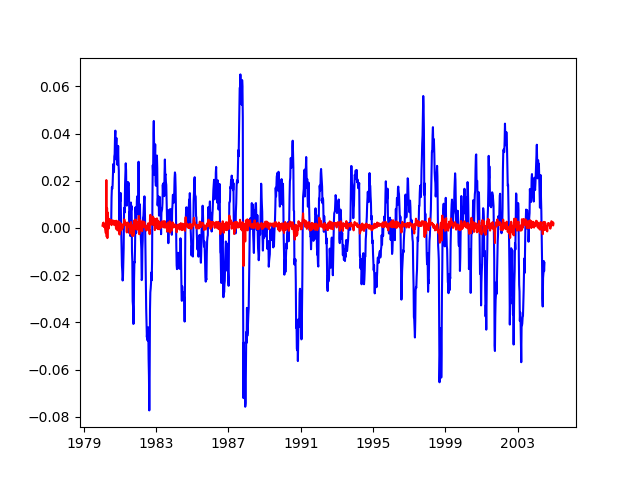

In [248]:
plt.figure()
plt.plot(residual,'b')
yfit= results_ARIMA.fittedvalues
plt.plot(yfit,'r')
plt.show()

In [187]:
train_dat.diff().mean()

0.00020422910161965505